In [1]:
# Import the modules that we will need.

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

import ratioclasses as rc

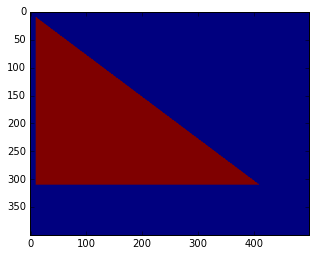

In [2]:
# We will test our methods of isoperimetric ratio calculation for triangles of different dimensions.

# Function to create triangle images

def maketriangle(pixelData, triHeight, triWidth):
    offset = [10, 10]
    pixelData = np.zeros(pixelData.shape)
    imHeight, imWidth = pixelData.shape
    
    for y in range(triHeight):
        for x in range(triWidth):
            if triWidth * y - triHeight * x > 0:
                pixelData[offset[0] + y, offset[1] + x] = 1
                
    return pixelData

# Function to compute Isoperimetric Ratio

def triangleRatio(triHeight, triWidth):
    perimeter = np.sqrt(triHeight**2 + triWidth**2)
    perimeter += triHeight + triWidth
    area = 0.5 * triHeight * triWidth
    return perimeter / np.sqrt(area)
    
    
# Test out maketriangle.

pixelData = np.zeros((400,500))
pixelData = maketriangle(pixelData, 300, 400)

imagePlot = plt.imshow(pixelData)
plt.show()

In [3]:
# Test out box counting for isoperimetric ratio calculation.

boxRatios = []
trueRatios = []
testWidths = range(100, 450, 25)
boxCounter = rc.BoxCount(pixelData)
triHeight = 300

for width in testWidths:
    pixelData = maketriangle(pixelData, triHeight, width)
    boxCounter.setpixeldata(pixelData)
    boxCounter.getcounts()
    boxRatios.append(boxCounter.getratio_minarea())
    trueRatios.append(triangleRatio(triHeight, width))
    
boxRatios = np.array(boxRatios)
trueRatios = np.array(trueRatios)

# There is a scaling issue, so just rescale the true ratios.

trueRatios *= boxRatios[0]/trueRatios[0]

np.array([boxRatios, trueRatios]).T

array([[ 12.38808443,  12.38808443],
       [ 11.65099217,  11.60270526],
       [ 11.18448507,  11.09184799],
       [ 10.83351905,  10.75152654],
       [ 10.60156349,  10.52486907],
       [ 10.42743536,  10.37777507],
       [ 10.30257107,  10.28839343],
       [ 10.21442151,  10.24200784],
       [ 10.15627392,  10.22832016],
       [ 10.19724289,  10.23990338],
       [ 10.26537083,  10.27126978],
       [ 10.34137786,  10.31828338],
       [ 10.4235489 ,  10.37777507],
       [ 10.50642641,  10.44728243]])

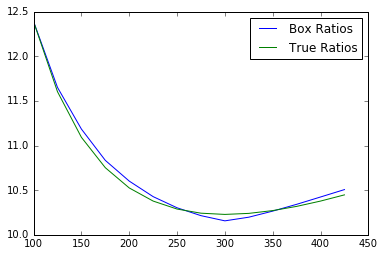

In [4]:
# Graph of box calculation of isoperimetric ratios versus the true ratios.

plt.plot(testWidths, boxRatios)
plt.plot(testWidths, trueRatios)
plt.legend(['Box Ratios', 'True Ratios'])
plt.show()

In [5]:
# Get an image to analyze and experiment with.

filePath = "Data/images/"
imageName = filePath + "634.jpg"
myImage = Image.open(imageName)
imWidth, imHeight = myImage.size
pixelData = myImage.getdata()
pixelData = np.array(pixelData, dtype = 'uint').reshape(imHeight, imWidth)

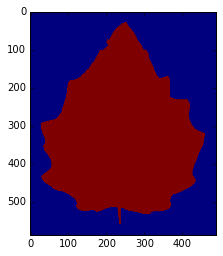

In [6]:
# Take a look at the image.

imagePlot = plt.imshow(pixelData)
plt.show()

In [7]:
# Take a look at the values in the image.

valuesInfo = np.unique(pixelData, return_counts = True)

valuesInfo

(array([  0,   1, 254, 255], dtype=uint32),
 array([150903,    228,    207, 136194], dtype=int64))

In [8]:
# Try segmenting the image into parts and applying linear fits to obtain geometric information about the boundary.

# Make output of image fitting.

fitted = np.zeros(pixelData.shape)

# Divide up each axis into segments.

nSegments = 15

dHeight = int(imHeight /  nSegments)
dWidth = int(imWidth / nSegments)

# Set up sample x and y values

xSamples = np.array(range(0, dWidth)).reshape(1, dWidth)
xSamples = np.repeat(xSamples, dHeight, axis = 0)
xSamples = xSamples.flatten()

ySamples = np.array(range(0, dHeight)).reshape(1, dHeight)
ySamples = np.repeat(ySamples, dWidth, axis = 0)
ySamples = ySamples.T.flatten()

depSamples = np.array([xSamples, ySamples]).T

# Make test for whether fit is necessary.

def regressionNecessary(imageSample):
    pixelMax = np.amax(imageSample)
    pixelMin = np.amin(imageSample)
    if pixelMin > 252:
        return False
    elif pixelMax < 3:
        return False
    else:
        return True
    
# Set up image model and fit each segment. Note that constant offset term is a part of PolynomialFeatures.
# So we don't need to find another intercept term during linear regression.
# Coefficients of Linear Regression should be [1, x, y, x^2, xy, y^2, x^3]

imageModel = make_pipeline(PolynomialFeatures(3), LinearRegression(fit_intercept = False))

for i0 in range(0,imHeight - dHeight,dHeight):
    for j0 in range(0, imWidth - dWidth, dWidth):

        imageSample = pixelData[i0:i0+dHeight, j0:j0+dWidth]
        if(regressionNecessary(imageSample)):
            imageSample = imageSample.flatten()
            imageModel.fit(depSamples, imageSample)
            prediction = imageModel.predict(depSamples)
            fitted[i0:i0+dHeight, j0:j0+dWidth] = prediction.reshape(dHeight, dWidth)
        else:
            fitted[i0:i0+dHeight, j0:j0+dWidth] = imageSample
        
imageModel.named_steps['linearregression'].coef_

array([  2.63113347e+00,   2.28501021e+01,  -1.80261254e+00,
        -1.51158498e+00,  -2.09955433e-01,  -9.21859405e-02,
         2.35645422e-02,   1.41801912e-02,  -3.72086002e-03,
         3.56738580e-03])

In [9]:
# Do a small test of coefficients in linear regression to make sure they match the correct polynomial features.

depSamples = np.array([[2,3]])
prediction = imageModel.predict(depSamples)

imageModel.named_steps['polynomialfeatures'].powers_

array([[0, 0],
       [1, 0],
       [0, 1],
       [2, 0],
       [1, 1],
       [0, 2],
       [3, 0],
       [2, 1],
       [1, 2],
       [0, 3]], dtype=int64)

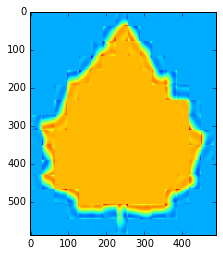

In [10]:
# Plot the fitted image

imagePlot = plt.imshow(fitted)
plt.show()

In [11]:
# Make function for obtaining ratio from pixed data

def findIsopRatio(pixelData, fitted, nSegments = 15):
    
    # Set up geometric quanitites
    
    variation = 0.0
    l2squared = 0.0
    
    # Get image data and divide axes into segments.
    
    imHeight, imWidth = pixelData.shape
    dWidth = int(imWidth / nSegments)
    dHeight = int(imHeight / nSegments)
    
    # Set up sample x and y values

    xSamples = np.array(range(0, dWidth)).reshape(1, dWidth)
    xSamples = np.repeat(xSamples, dHeight, axis = 0)
    xSamples = xSamples.flatten()

    ySamples = np.array(range(0, dHeight)).reshape(1, dHeight)
    ySamples = np.repeat(ySamples, dWidth, axis = 0)
    ySamples = ySamples.T.flatten()

    depSamples = np.array([xSamples, ySamples]).T
    
    # Set up image model and fit each segment. Note that constant offset term is a part of PolynomialFeatures.
    # So we don't need to find another intercept term during linear regression.
    # Coefficients of Linear Regression should be [1, x, y, x^2, xy, y^2, x^3, x^2y, xy^2, y^3]

    imageModel = make_pipeline(PolynomialFeatures(3), LinearRegression(fit_intercept = False))

    for i0 in range(0,imHeight - dHeight,dHeight):
        for j0 in range(0, imWidth - dWidth, dWidth):
    
            imageSample = pixelData[i0:i0+dHeight, j0:j0+dWidth]
            if(regressionNecessary(imageSample)):
                imageSample = imageSample.flatten()
                imageModel.fit(depSamples, imageSample)
                prediction = imageModel.predict(depSamples)
                fitted[i0:i0+dHeight, j0:j0+dWidth] = prediction.reshape(dHeight, dWidth)
            else:
                fitted[i0:i0+dHeight, j0:j0+dWidth] = imageSample
    
    
    

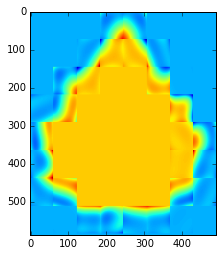

In [12]:
# Plot the fitted image

fitted = np.zeros(fitted.shape)
findIsopRatio(pixelData, fitted, nSegments = 8)
imagePlot = plt.imshow(fitted)
plt.show()